[INFO] Map generated in 0.0056s
[INFO] Graph built in 1.7355s
[INFO] Travel times and paths computed in 13.9720s
[INFO] Optimization completed in 0.1454s
[INFO] Torque computed in 0.0004s

[INFO] Response times per origin:
  Origin (27, 139) → Station (35, 122): 36.38
  Origin (6, 98) → Station (8, 92): 11.73
  Origin (70, 103) → Station (56, 97): 26.37
  Origin (63, 19) → Station (68, 11): 15.73
  Origin (57, 94) → Station (56, 97): 6.74
  Origin (36, 22) → Station (42, 22): 10.53
  Origin (26, 97) → Station (23, 107): 19.30
  Origin (139, 31) → Station (143, 30): 7.66
  Origin (21, 117) → Station (23, 107): 21.75
  Origin (108, 47) → Station (127, 51): 31.27
  Origin (8, 74) → Station (8, 92): 28.50
  Origin (7, 149) → Station (35, 122): 64.79
  Origin (24, 64) → Station (17, 61): 10.54
  Origin (56, 62) → Station (54, 71): 12.74
  Origin (60, 1) → Station (68, 11): 23.07
  Origin (129, 134) → Station (130, 134): 2.13
  Origin (7, 10) → Station (37, 1): 48.90
  Origin (144, 51) → Sta

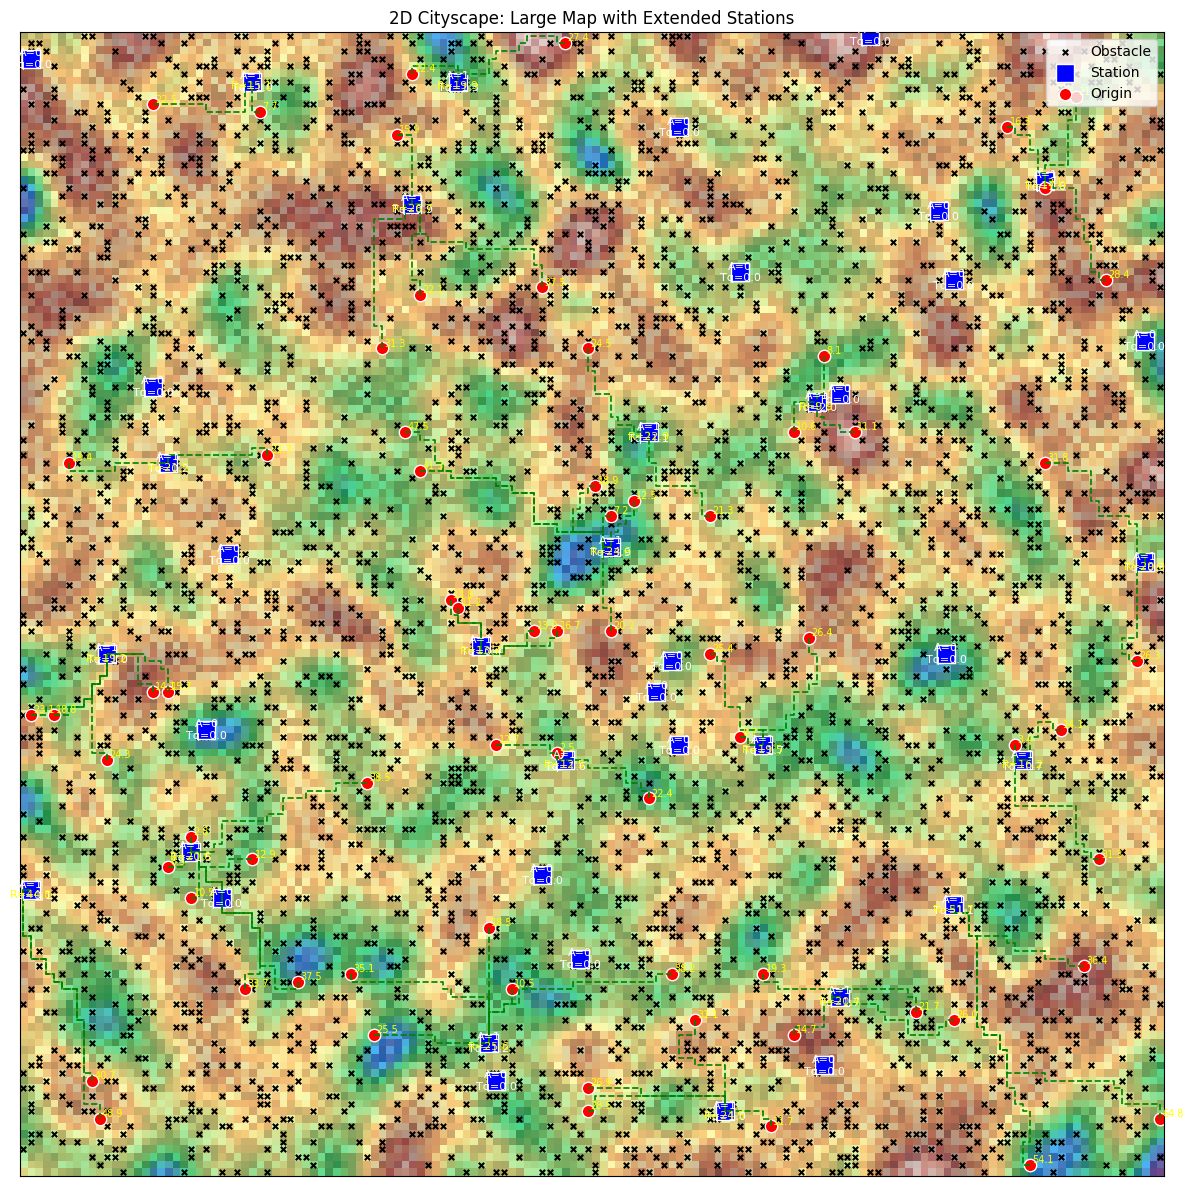

[INFO] Cityscape plotted in 0.6881s
Total execution time: 16.5635s


In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
from scipy.ndimage import gaussian_filter
import pulp

# 1. Generate synthetic map with elevation, traffic, and obstacles
def generate_map(width, height, obstacle_prob=0.1, traffic_scale=1.0, elev_smooth=3):
    """
    Generates a synthetic map with elevation, traffic, and obstacles.

    Parameters:
        width (int): Width of the map.
        height (int): Height of the map.
        obstacle_prob (float): Probability of an obstacle at any cell.
        traffic_scale (float): Scale factor for traffic intensity.
        elev_smooth (int): Smoothing factor for elevation.

    Returns:
        tuple: Elevation matrix, traffic matrix, and obstacle matrix.
    """
    start = time.time()
    elevation = np.random.rand(height, width)
    elevation = gaussian_filter(elevation, sigma=elev_smooth)
    elevation = (elevation - elevation.min()) / (elevation.max() - elevation.min())

    traffic = np.random.rand(height, width) * traffic_scale + 0.5
    obstacles = np.random.rand(height, width) < obstacle_prob

    print(f"[INFO] Map generated in {time.time() - start:.4f}s")
    return elevation, traffic, obstacles

# 2. Build grid graph with weighted edges based on elevation slope and traffic
def build_graph(elevation, traffic, obstacles, slope_cost=2.0):
    """
    Builds a directed graph representing the map, with weighted edges based on elevation slope and traffic.

    Parameters:
        elevation (ndarray): Elevation matrix.
        traffic (ndarray): Traffic matrix.
        obstacles (ndarray): Obstacle matrix.
        slope_cost (float): Cost multiplier for elevation slope.

    Returns:
        nx.DiGraph: Directed graph representing the map.
    """
    start = time.time()
    height, width = elevation.shape
    graph = nx.DiGraph()

    for i in range(height):
        for j in range(width):
            if obstacles[i, j]:
                continue
            graph.add_node((i, j))

            for di, dj in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < height and 0 <= nj < width and not obstacles[ni, nj]:
                    distance = 1.0
                    slope = abs(elevation[ni, nj] - elevation[i, j])
                    traffic_multiplier = (traffic[i, j] + traffic[ni, nj]) / 2
                    weight = distance * (1 + slope_cost * slope) * traffic_multiplier
                    graph.add_edge((i, j), (ni, nj), weight=weight)

    print(f"[INFO] Graph built in {time.time() - start:.4f}s")
    return graph

# 3. Compute shortest-path travel times and paths
def compute_travel_time_and_paths(graph, origins, stations):
    """
    Computes shortest-path travel times and paths between origins and stations.

    Parameters:
        graph (nx.DiGraph): Directed graph representing the map.
        origins (list): List of origin nodes.
        stations (list): List of station nodes.

    Returns:
        tuple: Travel times dictionary and paths dictionary.
    """
    start = time.time()
    travel_times = {}
    paths = {}

    for origin in origins:
        try:
            lengths, path_dict = nx.single_source_dijkstra(graph, origin, weight='weight')
        except nx.NetworkXError:
            lengths, path_dict = {}, {}

        for station in stations:
            travel_times[(origin, station)] = lengths.get(station, np.inf)
            if station in path_dict:
                paths[(origin, station)] = path_dict[station]

    print(f"[INFO] Travel times and paths computed in {time.time() - start:.4f}s")
    return travel_times, paths

# 4. Optimize ambulance dispatch
def optimize_dispatch(origins, stations, demand_weights, travel_times, total_ambulances, max_travel_time):
    """
    Solves the optimization problem for ambulance dispatch.

    Parameters:
        origins (list): List of origin nodes.
        stations (list): List of station nodes.
        demand_weights (dict): Demand weights for each origin.
        travel_times (dict): Travel times between origins and stations.
        total_ambulances (int): Total number of ambulances available.
        max_travel_time (float): Maximum allowable travel time.

    Returns:
        tuple: Ambulance allocation, assignment, and optimization problem.
    """
    start = time.time()
    valid_pairs = [(o, s) for o in origins for s in stations if travel_times.get((o, s), np.inf) <= max_travel_time]

    prob = pulp.LpProblem('AmbulanceDispatch', pulp.LpMinimize)

    ambulance_count = pulp.LpVariable.dicts('ambulance_count', stations, lowBound=0, upBound=total_ambulances, cat='Integer')
    assignment = pulp.LpVariable.dicts('assignment', valid_pairs, cat='Binary')

    prob += pulp.lpSum(demand_weights[o] * travel_times[o, s] * assignment[(o, s)] for (o, s) in valid_pairs)

    prob += pulp.lpSum(ambulance_count[s] for s in stations) == total_ambulances

    for o in origins:
        valid_stations = [s for (oo, s) in valid_pairs if oo == o]
        if valid_stations:
            prob += pulp.lpSum(assignment[(o, s)] for s in valid_stations) >= 1
        for s in stations:
            if (o, s) in valid_pairs:
                prob += assignment[(o, s)] <= ambulance_count[s]

    prob.solve(pulp.PULP_CBC_CMD(msg=False))

    print(f"[INFO] Optimization completed in {time.time() - start:.4f}s")
    ambulance_allocation = {s: int(ambulance_count[s].varValue or 0) for s in stations}
    assignment_result = {(o, s): int(assignment[(o, s)].varValue or 0) for (o, s) in valid_pairs}
    return ambulance_allocation, assignment_result, prob
# 5. Compute torque per station based on assigned origins
def compute_torque(elevation, origins, stations, assignment, demand_weights, radius=1.0, g=9.81):
    """
    Computes the torque for each station based on the assigned origins.

    Parameters:
        elevation (ndarray): Elevation matrix.
        origins (list): List of origin nodes.
        stations (list): List of station nodes.
        assignment (dict): Assignment of origins to stations.
        demand_weights (dict): Demand weights for each origin.
        radius (float): Radius of the torque arm.
        g (float): Gravitational constant.

    Returns:
        dict: Torque values for each station.
    """
    start = time.time()
    torque = {}

    for station in stations:
        total_torque = 0.0
        station_elevation = elevation[station[0], station[1]]

        for origin in origins:
            if assignment.get((origin, station), 0) > 0:
                origin_elevation = elevation[origin[0], origin[1]]
                distance = np.hypot(origin[0] - station[0], origin[1] - station[1]) or 1.0
                slope = abs(origin_elevation - station_elevation) / distance
                total_torque += demand_weights[origin] * g * slope * radius

        torque[station] = total_torque

    print(f"[INFO] Torque computed in {time.time() - start:.4f}s")
    return torque

# 6. Compute and print response times per origin
def compute_and_print_response_times(travel_time, assignment):
    """
    Computes and prints the response times for each origin.

    Parameters:
        travel_time (dict): Travel times between origins and stations.
        assignment (dict): Assignment of origins to stations.

    Returns:
        dict: Response times for each origin.
    """
    response_times = {}
    print("\n[INFO] Response times per origin:")

    for (origin, station), assigned in assignment.items():
        if assigned:
            time = travel_time[origin, station]
            response_times[origin] = time
            print(f"  Origin {origin} → Station {station}: {time:.2f}")

    return response_times

# 7. Compute and print response times per station
def compute_and_print_station_response_times(travel_time, assignment):
    """
    Computes and prints the response times for each station.

    Parameters:
        travel_time (dict): Travel times between origins and stations.
        assignment (dict): Assignment of origins to stations.

    Returns:
        dict: Response times for each station.
    """
    station_times = {}
    print("\n[INFO] Response times per station:")

    for (origin, station), assigned in assignment.items():
        if assigned:
            time = travel_time[origin, station]
            station_times.setdefault(station, []).append(time)

    for station, times in station_times.items():
        min_time = min(times)
        max_time = max(times)
        avg_time = sum(times) / len(times)
        print(f"  Station {station}: served {len(times)} calls, "
              f"min={min_time:.2f}, avg={avg_time:.2f}, max={max_time:.2f}")

    return station_times

# 8. Plot 2D cityscape with paths and times
def plot_cityscape_2d(elevation, traffic, obstacles, origins, stations, ambulance_count, assignment, torque, paths, response_times, station_times, elev_cmap='terrain'):
    """
    Plots a 2D cityscape with elevation, traffic, obstacles, and paths.

    Parameters:
        elevation (ndarray): Elevation matrix.
        traffic (ndarray): Traffic matrix.
        obstacles (ndarray): Obstacle matrix.
        origins (list): List of origin nodes.
        stations (list): List of station nodes.
        ambulance_count (dict): Number of ambulances at each station.
        assignment (dict): Assignment of origins to stations.
        torque (dict): Torque values for each station.
        paths (dict): Shortest paths between origins and stations.
        response_times (dict): Response times for each origin.
        station_times (dict): Response times for each station.
        elev_cmap (str): Colormap for elevation.

    Returns:
        None
    """
    start = time.time()
    height, width = elevation.shape
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot elevation
    ax.imshow(elevation, cmap=elev_cmap, origin='lower')

    # Overlay traffic
    traffic_norm = (traffic - traffic.min()) / (traffic.max() - traffic.min())
    ax.imshow(traffic_norm, cmap='Reds', alpha=0.3, origin='lower')

    # Plot obstacles
    obs_y, obs_x = np.where(obstacles)
    ax.scatter(obs_x, obs_y, c='black', s=15, marker='x', label='Obstacle')

    # Plot paths
    for (origin, station), assigned in assignment.items():
        if assigned:
            path = paths.get((origin, station), [])
            xs = [node[1] for node in path]
            ys = [node[0] for node in path]
            ax.plot(xs, ys, '--', lw=1.2, color='green')

    # Plot stations
    for station in stations:
        j, i = station[1], station[0]
        ax.scatter(j, i, c='blue', s=180, marker='s', edgecolors='white', label='Station' if 'Station' not in ax.get_legend_handles_labels()[1] else "")
        ax.text(j, i, f"A={ambulance_count[station]}\nTq={torque[station]:.1f}", color='white', ha='center', va='center', fontsize=8)
        if station in station_times:
            avg_time = sum(station_times[station]) / len(station_times[station])
            ax.text(j, i - 0.6, f"R={avg_time:.1f}", color='yellow', ha='center', va='center', fontsize=8)

    # Plot origins
    for origin in origins:
        j, i = origin[1], origin[0]
        ax.scatter(j, i, c='red', s=80, marker='o', edgecolors='white', label='Origin' if 'Origin' not in ax.get_legend_handles_labels()[1] else "")
        if origin in response_times:
            ax.text(j + 0.3, i + 0.3, f"{response_times[origin]:.1f}", color='yellow', fontsize=7)

    # Finalize plot
    ax.set_title('2D Cityscape: Large Map with Extended Stations')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    print(f"[INFO] Cityscape plotted in {time.time() - start:.4f}s")
# 9. Main execution with larger map & more stations
if __name__ == '__main__':
    random.seed(42)
    np.random.seed(42)
    total_start = time.time()
    # Larger map dimensions
    W, H = 150, 150
    # More demand zones and stations
    num_origins = 70
    num_stations = 40

    elev, traffic, obstacles = generate_map(W, H, obstacle_prob=0.15, traffic_scale=2.0)
    G = build_graph(elev, traffic, obstacles)
    nodes = list(G.nodes())
    sample = random.sample(nodes, k=num_origins + num_stations)
    origins = sample[:num_origins]
    stations = sample[num_origins:]

    demand_weights = {o: random.uniform(1,5) for o in origins}
    travel_time, paths = compute_travel_time_and_paths(G, origins, stations)
    K, Tmax = 20, 100.0  # increased fleet size and threshold

    ambulance_count, assignment, prob = optimize_dispatch(origins, stations, demand_weights, travel_time, K, Tmax)
    torque = compute_torque(elev, origins, stations, assignment, demand_weights)
    response_times = compute_and_print_response_times(travel_time, assignment)
    station_times = compute_and_print_station_response_times(travel_time, assignment)
    print("\nOptimization Status:", pulp.LpStatus[prob.status])
    for s in stations:
        print(f"Station {s}: ambulances={ambulance_count[s]}, torque={torque[s]:.1f}")

    plot_cityscape_2d(elev, traffic, obstacles, origins, stations, ambulance_count, assignment, torque, paths, response_times, station_times)
    print(f"Total execution time: {time.time() - total_start:.4f}s")


In [ ]:
import osmnx as ox
import networkx as nx
import random
import pulp
import matplotlib.pyplot as plt

def fetch_nyc_graph():
    """
    Fetches and processes a road network graph for mid-Manhattan.
    # ... (rest of docstring) ...
    """
    # Define bounding box coordinates for mid-Manhattan
    north, south, east, west = 40.80, 40.70, -73.95, -74.02

    # Create a tuple from the coordinates
    bbox_coords = (north, south, east, west) # Note: Check if the order should be (west, south, east, north) as is common

    # Fetch the road network graph passing the tuple as the first argument
    # and network_type as a keyword argument
    graph = ox.graph_from_bbox(bbox_coords, network_type='drive')

    # Project the graph to a metric CRS (EPSG:2263 - NAD83 / New York Long Island)
    graph = ox.project_graph(graph, to_crs='EPSG:2263')

    # Define default speed in feet per second (30 mph)
    default_speed_fps = 30 * 5280 / 3600

    # Compute travel time for each edge
    for u, v, k, data in graph.edges(keys=True, data=True):
        length = data.get('length', 0)  # Edge length in feet
        speed = data.get('maxspeed_fps', default_speed_fps)  # Speed in feet per second
        # Ensure speed is not zero to avoid division by zero error
        if speed > 0:
            data['travel_time'] = length / speed  # Travel time in seconds
        else:
            data['travel_time'] = float('inf') # Assign infinite travel time if speed is zero

    return graph

def snap_hospitals(G):
    # sample Manhattan hospital lat/lngs
    hospitals = {
        'Bellevue': (40.7391, -73.9754),
        'MountSinaiWest': (40.7675, -73.9854),
        'NYU_Tisch': (40.7420, -73.9740),
        'LenoxHill': (40.7735, -73.9590),
        'MS_Morningside': (40.7987, -73.9627),
    }
    # build GeoDataFrame and project
    gdf = ox.geocode_to_gdf(list(hospitals.values()), to_crs=G.graph['crs'])
    # snap to nearest nodes
    station_nodes = {}
    for name, (coord, row) in zip(hospitals.keys(), gdf.iterrows()):
        x, y = row.geometry.x, row.geometry.y
        nid = ox.nearest_nodes(G, X=x, Y=y)
        station_nodes[name] = nid
    return station_nodes

def sample_origins(G, k=50):
    nodes = list(G.nodes())
    random.seed(42)
    return random.sample(nodes, k)

def compute_travel_times(G, origins, stations):
    tt = {}
    paths = {}
    for o in origins:
        lengths, pathdict = nx.single_source_dijkstra(G, o, weight='travel_time')
        for s in stations:
            tt[(o,s)] = lengths.get(s, float('inf'))
            if s in pathdict:
                paths[(o,s)] = pathdict[s]
    return tt, paths

def optimize_dispatch(origins, stations, demand, tt, total_amb=5, max_t=600):
    valid = [(o,s) for o in origins for s in stations if tt[(o,s)] <= max_t]
    prob = pulp.LpProblem('NYC_Ambulance', pulp.LpMinimize)
    amb_count = pulp.LpVariable.dicts('amb', stations, lowBound=0, upBound=total_amb, cat='Integer')
    assign = pulp.LpVariable.dicts('asgn', valid, cat='Binary')
    # objective
    prob += pulp.lpSum(demand[o] * tt[o,s] * assign[(o,s)] for (o,s) in valid)
    # total ambulances
    prob += pulp.lpSum(amb_count[s] for s in stations) == total_amb
    # each origin must be served by ≥1 ambulance
    for o in origins:
        vs = [s for (oo,s) in valid if oo==o]
        if vs:
            prob += pulp.lpSum(assign[(o,s)] for s in vs) >= 1
    # can't assign from a station with no ambulance
    for (o,s) in valid:
        prob += assign[(o,s)] <= amb_count[s]
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    return {s:int(amb_count[s].varValue) for s in stations}, {(o,s):int(assign[(o,s)].varValue) for (o,s) in valid}

def plot_results(G, origins, station_nodes, amb_alloc, assignment, paths):
    fig, ax = ox.plot_graph(G, show=False, close=False, figsize=(8,8))
    # draw assignments
    for (o,s), val in assignment.items():
        if val:
            path = paths[(o,s)]
            xs = [G.nodes[n]['x'] for n in path]
            ys = [G.nodes[n]['y'] for n in path]
            ax.plot(xs, ys, '--', linewidth=0.5, alpha=0.7)
    # plot hospitals
    xs = [G.nodes[n]['x'] for n in station_nodes.values()]
    ys = [G.nodes[n]['y'] for n in station_nodes.values()]
    ax.scatter(xs, ys, c='red', s=100, marker='^')
    for name, n in station_nodes.items():
        ax.annotate(f"{name}\nA={amb_alloc[n]}", 
                    (G.nodes[n]['x'], G.nodes[n]['y']),
                    textcoords="offset points", xytext=(0,5), ha='center', color='darkred')
    plt.show()

if __name__=='__main__':
    # 1. Load graph
    G = fetch_nyc_graph()
    # 2. Hospitals → stations
    stations = snap_hospitals(G)
    station_nodes = list(stations.values())
    # 3. Origins
    origins = sample_origins(G, k=50)
    demand = {o:1.0 for o in origins}
    # 4. Travel times & paths
    tt, paths = compute_travel_times(G, origins, station_nodes)
    # 5. Optimize dispatch
    amb_alloc, assignment = optimize_dispatch(origins, station_nodes, demand, tt)
    print("Ambulance allocation per station:")
    for name,n in stations.items():
        print(f"  {name}: {amb_alloc[n]} ambulances")
    # 6. Plot
    plot_results(G, origins, stations, amb_alloc, assignment, paths)


TypeError: graph_from_bbox() takes 1 positional argument but 4 positional arguments (and 1 keyword-only argument) were given